In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Processing 1,429,740 rows in chunks of 200,000...


Adding temporal features: 100%|██████████| 8/8 [00:15<00:00,  2.00s/it]


✅ Temporal features added for 1,429,740 rows

--- Temporal Features Sample ---
        date  day_of_year  month  season  week_of_year  day_of_year_sin  \
0 2024-01-08            8      1       1             2         0.137185   
1 2024-01-09            9      1       1             2         0.154204   
2 2024-01-10           10      1       1             2         0.171177   
3 2024-01-11           11      1       1             2         0.188099   
4 2024-01-12           12      1       1             2         0.204966   
5 2024-01-13           13      1       1             2         0.221772   
6 2024-01-14           14      1       1             2         0.238513   
7 2024-01-15           15      1       1             3         0.255182   
8 2024-01-16           16      1       1             3         0.271777   
9 2024-01-17           17      1       1             3         0.288291   

   day_of_year_cos  
0         0.990545  
1         0.988039  
2         0.985240  
3         0

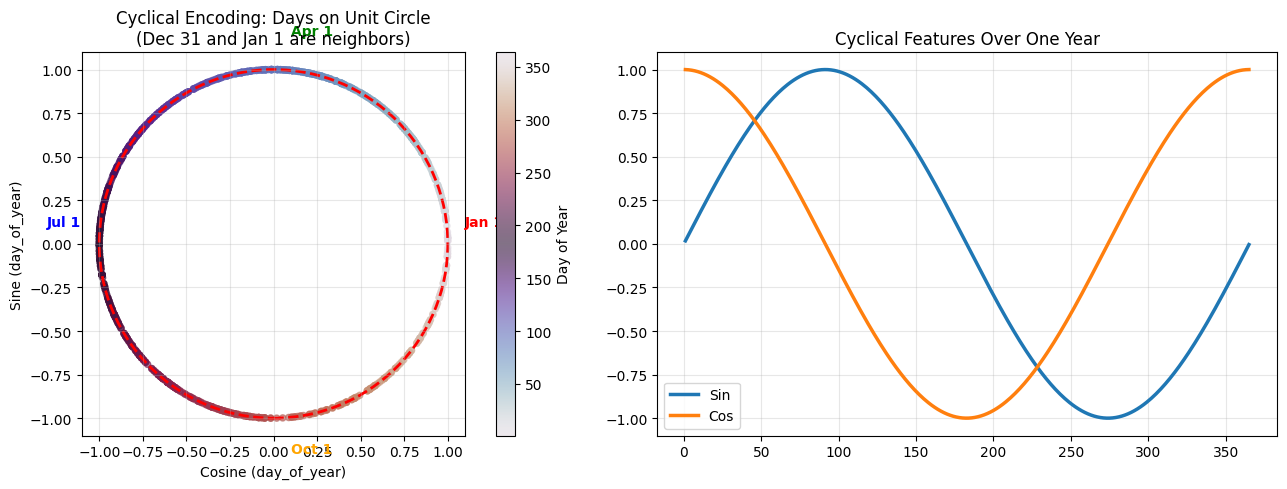


--- Data Coverage ---
Date range: 2024-01-08 00:00:00 → 2025-09-29 00:00:00
Unique days: 361 | Total samples: 1,429,740
✅ Temporal features ready for modeling!


In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# CELL: Add Temporal Features (CHUNKED + tqdm)
# ============================================

def add_temporal_features_chunked(file_path, output_path=None, chunk_size=200000):
    """
    Efficiently add temporal features to a large CSV using chunk processing and tqdm progress bars.
    Returns concatenated DataFrame or writes output to disk.
    """
    all_chunks = []
    total_rows = sum(1 for _ in open(file_path)) - 1  # header excluded
    print(f"Processing {total_rows:,} rows in chunks of {chunk_size:,}...")

    # Chunked reading with tqdm progress bar
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunk_size, parse_dates=['date']), total=total_rows//chunk_size + 1, desc="Adding temporal features"):
        chunk['date'] = pd.to_datetime(chunk['date'])
        
        # Basic temporal features
        chunk['day_of_year'] = chunk['date'].dt.dayofyear
        chunk['month'] = chunk['date'].dt.month
        chunk['season'] = (chunk['month'] % 12 + 3) // 3
        chunk['week_of_year'] = chunk['date'].dt.isocalendar().week

        # Cyclical encoding
        chunk['day_of_year_sin'] = np.sin(2 * np.pi * chunk['day_of_year'] / 365.25)
        chunk['day_of_year_cos'] = np.cos(2 * np.pi * chunk['day_of_year'] / 365.25)
        
        all_chunks.append(chunk)
    
    df = pd.concat(all_chunks, ignore_index=True)
    print(f"✅ Temporal features added for {len(df):,} rows")

    if output_path:
        df.to_csv(output_path, index=False)
        print(f"💾 Saved to {output_path}")
    return df


# === Run it on your file or DataFrame ===
# (use X_agg.to_csv(...) before if your data is still in memory)
# Example:
df = add_temporal_features_chunked("era5_all_window_features.csv")

# If already in memory (smaller dataset)
# X_agg = add_temporal_features(X_agg)

# ============================================
# Visualization and inspection (unchanged)
# ============================================

print("\n--- Temporal Features Sample ---")
temporal_cols = ['date', 'day_of_year', 'month', 'season', 'week_of_year',
                 'day_of_year_sin', 'day_of_year_cos']
print(df[temporal_cols].head(10))

# --- Visualization (unchanged) ---
print("\n--- Cyclical Encoding Visualization ---")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter on unit circle
sample_days = df.sample(min(1000, len(df)))
scatter = axes[0].scatter(sample_days['day_of_year_cos'],
                          sample_days['day_of_year_sin'],
                          c=sample_days['day_of_year'],
                          cmap='twilight', alpha=0.6, s=20)
axes[0].set_xlabel('Cosine (day_of_year)')
axes[0].set_ylabel('Sine (day_of_year)')
axes[0].set_title('Cyclical Encoding: Days on Unit Circle\n(Dec 31 and Jan 1 are neighbors)')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')
axes[0].add_patch(plt.Circle((0, 0), 1, fill=False, color='red', linestyle='--', linewidth=2))
plt.colorbar(scatter, ax=axes[0], label='Day of Year')

# Annotate
axes[0].annotate('Jan 1', xy=(1, 0), xytext=(1.1, 0.1), color='red', fontweight='bold')
axes[0].annotate('Jul 1', xy=(-1, 0), xytext=(-1.3, 0.1), color='blue', fontweight='bold')
axes[0].annotate('Apr 1', xy=(0, 1), xytext=(0.1, 1.2), color='green', fontweight='bold')
axes[0].annotate('Oct 1', xy=(0, -1), xytext=(0.1, -1.2), color='orange', fontweight='bold')

# Sin/Cos over year
days_theoretical = np.arange(1, 366)
sin_theoretical = np.sin(2 * np.pi * days_theoretical / 365.25)
cos_theoretical = np.cos(2 * np.pi * days_theoretical / 365.25)
axes[1].plot(days_theoretical, sin_theoretical, label='Sin', linewidth=2.5)
axes[1].plot(days_theoretical, cos_theoretical, label='Cos', linewidth=2.5)
axes[1].set_title('Cyclical Features Over One Year')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n--- Data Coverage ---")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print(f"Unique days: {df['day_of_year'].nunique()} | Total samples: {len(df):,}")
print("✅ Temporal features ready for modeling!")


In [3]:
list(df.columns)

['date',
 'latitude',
 'longitude',
 't2m_min_mean',
 't2m_min_std',
 't2m_min_min',
 't2m_min_max',
 't2m_min_first',
 't2m_min_last',
 't2m_min_trend',
 't2m_min_recent_3d',
 't2m_max_mean',
 't2m_max_std',
 't2m_max_min',
 't2m_max_max',
 't2m_max_first',
 't2m_max_last',
 't2m_max_trend',
 't2m_max_recent_3d',
 't2m_mean_mean',
 't2m_mean_std',
 't2m_mean_min',
 't2m_mean_max',
 't2m_mean_first',
 't2m_mean_last',
 't2m_mean_trend',
 't2m_mean_recent_3d',
 'd2m_min_mean',
 'd2m_min_std',
 'd2m_min_min',
 'd2m_min_max',
 'd2m_min_first',
 'd2m_min_last',
 'd2m_min_trend',
 'd2m_min_recent_3d',
 'd2m_max_mean',
 'd2m_max_std',
 'd2m_max_min',
 'd2m_max_max',
 'd2m_max_first',
 'd2m_max_last',
 'd2m_max_trend',
 'd2m_max_recent_3d',
 'd2m_mean_mean',
 'd2m_mean_std',
 'd2m_mean_min',
 'd2m_mean_max',
 'd2m_mean_first',
 'd2m_mean_last',
 'd2m_mean_trend',
 'd2m_mean_recent_3d',
 'msl_min_mean',
 'msl_min_std',
 'msl_min_min',
 'msl_min_max',
 'msl_min_first',
 'msl_min_last',
 'msl_mi

In [4]:
df['es_d2m'] = 6.112 * np.exp((17.67 * df['d2m_mean_mean']) / (df['d2m_mean_mean'] + 243.5))
df['es_t2m'] = 6.112 * np.exp((17.67 * df['t2m_mean_mean']) / (df['t2m_mean_mean'] + 243.5))


In [5]:
df['RH'] = 100 * df['es_d2m'] / df['es_t2m']


In [6]:
df['w'] = 0.622 * df['es_d2m'] / (df['msl_mean_mean'] - df['es_d2m'])
df['Tv'] = df['t2m_mean_mean'] * (1 + 0.61 * df['w'])


In [7]:
df['wind_speed'] = np.sqrt(df['u10_mean_mean']**2 + df['v10_mean_mean']**2)
df['wind_dir'] = np.degrees(np.arctan2(df['v10_mean_mean'], df['u10_mean_mean']))


In [8]:
df['delta_sk'] = df['skt_mean_mean'] - df['t2m_mean_mean']


In [9]:
df['CRI'] = (df['tcc_mean_mean'] / 100) * df['delta_sk']


In [10]:
df['msl_tendency'] = df['msl_mean_trend']


In [11]:
df['RH_trend'] = 100 * (
    (6.112 * np.exp((17.67 * df['d2m_mean_trend']) / (df['d2m_mean_trend'] + 243.5))) /
    (6.112 * np.exp((17.67 * df['t2m_mean_trend']) / (df['t2m_mean_trend'] + 243.5)))
)


In [12]:
df.to_csv('weather_features.csv', index=False)